# Music Recognition Demo

This notebook demonstrates the MusicTrOCR model for Optical Music Recognition with transposition capabilities.

## Features
- Image to BeKern notation conversion 
- Music score rendering with Verovio
- Transposition of predicted music
- Side-by-side comparisons

In [1]:
# Configuration and imports
import warnings
warnings.filterwarnings('ignore')

from demo_utils import (
    load_model_and_vocab, 
    preprocess_image, 
    run_inference, 
    decode_bekern_prediction,
    bekern_to_kern,
    render_with_transposition,
    display_image_and_prediction,
    display_comparison
)

# Configuration
IMG_PATH = "../demos/demo3.png"
CKPT_PATH = "../networks/checkpoints/luca_model/stage_1/best_checkpoint.pt"
VOCAB_PATH = "../data/FP_GrandStaff_BeKernw2i.npy"
TRANSPOSE_SEMITONES = 5  # Change this to transpose up/down (0 = no transposition)

In [2]:
# Load model and preprocess image
print("Loading model and vocabulary...")
model, vocab_dict, id_to_token = load_model_and_vocab(CKPT_PATH, VOCAB_PATH)

print("Preprocessing image...")
image_tensor = preprocess_image(IMG_PATH)

print("✅ Model and data ready!")

Loading model and vocabulary...
Special token IDs: PAD=0, BOS=169, EOS=72
Loaded pretrained facebook/convnext-tiny-224 with output dim 768
Loaded pretrained facebook/convnext-tiny-224 with output dim 768
MusicTrOCR initialized with 56,016,149 parameters
MusicTrOCR initialized with 56,016,149 parameters
Model loaded from ../networks/checkpoints/luca_model/stage_1/best_checkpoint.pt
Vocabulary size: 181
Device: cuda
Preprocessing image...
Image preprocessed: ../demos/demo3.png
Original size: 897x264
Tensor size: torch.Size([1, 3, 128, 434])
✅ Model and data ready!
Model loaded from ../networks/checkpoints/luca_model/stage_1/best_checkpoint.pt
Vocabulary size: 181
Device: cuda
Preprocessing image...
Image preprocessed: ../demos/demo3.png
Original size: 897x264
Tensor size: torch.Size([1, 3, 128, 434])
✅ Model and data ready!


In [3]:
# Run model inference and decode prediction
print("Running model inference...")
predictions = run_inference(model, image_tensor, vocab_dict, max_length=512)

print("Decoding predictions to BeKern notation...")
bekern_str = decode_bekern_prediction(predictions, id_to_token, model)

print("Converting to Kern format...")
kern_str = bekern_to_kern(bekern_str)

print(f"✅ Prediction completed! Generated {len(bekern_str.split())} tokens")
print(f"BeKern preview: {bekern_str[:100]}{'...' if len(bekern_str) > 100 else ''}")

Running model inference...
Running inference with BeKern vocabulary...
Model special tokens: PAD=0, BOS=169, EOS=72
Generated sequence length: 21 (including BOS token)
Decoding predictions to BeKern notation...

=== DECODING BEKERN TOKENS ===
Model output tokens: [169, 143, 135, 143, 51, 118, 66, 143, 173, 143, 173, 143, 66, 118, 110, 143, 110, 143, 110, 118, 72]
Model special tokens: BOS=169, EOS=72, PAD=0
  Step 0: token_id=169 -> BOS (skipping)
  Step 1: token_id=143 -> '<t>'
  Step 2: token_id=135 -> '*clefF4'
  Step 3: token_id=143 -> '<t>'
  Step 4: token_id=51 -> '*clefG2'
  Step 5: token_id=118 -> '<b>'
  Step 6: token_id=66 -> '*'
  Step 7: token_id=143 -> '<t>'
  Step 8: token_id=173 -> '*v'
  Step 9: token_id=143 -> '<t>'
  Step 10: token_id=173 -> '*v'
  Step 11: token_id=143 -> '<t>'
  Step 12: token_id=66 -> '*'
  Step 13: token_id=118 -> '<b>'
  Step 14: token_id=110 -> '*-'
  Step 15: token_id=143 -> '<t>'
  Step 16: token_id=110 -> '*-'
  Step 17: token_id=143 -> '<t>'

In [4]:
# Load ground truth and compare with prediction
import os
import re

# Load ground truth from semantic file
GT_PATH = "../demos/demo3.semantic"
print("Loading ground truth from semantic file...")

def parse_bekern_content(content: str):
    """
    Parse bekern content using SMT-compatible logic.
    Adapted from data/utils/format_converter.py _parse_bekern_content function.
    """
    # Step 1: Clean the content (adapted from SMT's clean_kern)
    lines = content.split('\n')
    cleaned_lines = []
    avoid_tokens = ['*Xped', '*staff1', '*staff2', '*tremolo', '*ped', '*Xtuplet', '*tuplet', 
                   "*Xtremolo", '*cue', '*Xcue', '*rscale:1/2', '*rscale:1', '*kcancel', '*below']
    
    for line in lines:
        # Skip lines containing avoid tokens
        if not any(token in line.split('\t') for token in avoid_tokens):
            # Skip lines with only '*' tokens
            if not all(token == '*' for token in line.split('\t')):
                cleaned_lines.append(line.replace("\n", ""))
    
    krn = "\n".join(cleaned_lines)
    
    # Step 2: Remove measure numbers (e.g., =1, =25 becomes =)
    krn = re.sub(r'(?<=\=)\d+', '', krn)
    
    # Step 3: Replace structural elements with tokens (SMT bekern format)
    krn = krn.replace(" ", " <s> ")    # Space becomes <s>
    krn = krn.replace("\t", " <t> ")   # Tab becomes <t>  
    krn = krn.replace("\n", " <b> ")   # Newline becomes <b>
    
    # Step 4: Clean up specific patterns
    krn = krn.replace("·/", "")
    krn = krn.replace("·\\", "")
    
    # Step 5: BeKern format specific processing
    krn = krn.replace("·", " ")        # Dots become spaces
    krn = krn.replace("@", " ")        # @ symbols become spaces
    
    # Step 6: Split into tokens and clean up
    tokens = krn.strip().split(" ")
    tokens = [token for token in tokens if token.strip()]  # Remove empty tokens
    
    # Step 7: Skip the header tokens (first few **kern/**ekern/**bekern tokens)
    # Find where actual music content starts (after headers)
    header_count = 0
    for i, token in enumerate(tokens):
        if token.startswith('**'):
            header_count += 1
        else:
            break
    
    # Skip header tokens (typically 2-4 tokens like **kern **kern)
    if header_count > 0:
        tokens = tokens[header_count:]
    
    # Step 8: Remove any remaining **ekern tokens and leading <b> tokens
    tokens = [token for token in tokens if not token.startswith('**ekern')]
    
    # Remove leading <b> tokens
    while tokens and tokens[1] == '<b>':
        tokens.pop(0)
    
    return tokens

with open(GT_PATH, 'r') as f:
    gt_content = f.read()

# Parse ground truth using the same method as data loading
gt_tokens = parse_bekern_content(gt_content)

# Parse predicted tokens from BeKern string
pred_tokens = bekern_str.split()

print(f"Ground truth tokens: {len(gt_tokens)}")
print(f"Predicted tokens: {len(pred_tokens)}")

# Calculate token-level accuracy
min_length = min(len(gt_tokens), len(pred_tokens))
correct_tokens = 0

print("\nToken comparison (first 20 tokens):")
print("GT Token\t\tPred Token\t\tMatch")
print("-" * 50)

for i in range(len(gt_tokens)):
    gt_token = gt_tokens[i]
    pred_token = pred_tokens[i]
    match = "✓" if gt_token == pred_token else "✗"
    if gt_token == pred_token:
        correct_tokens += 1
    print(f"{gt_token:<15}\t{pred_token:<15}\t{match}")

# Count remaining correct tokens without printing
for i in range(20, min_length):
    if gt_tokens[i] == pred_tokens[i]:
        correct_tokens += 1

# Calculate accuracy metrics
token_accuracy = correct_tokens / min_length if min_length > 0 else 0
length_accuracy = min_length / max(len(gt_tokens), len(pred_tokens)) if max(len(gt_tokens), len(pred_tokens)) > 0 else 0

print(f"\n📊 Evaluation Results:")
print(f"Token-level accuracy: {correct_tokens}/{min_length} = {token_accuracy:.3f} ({token_accuracy*100:.1f}%)")
print(f"Length accuracy: {length_accuracy:.3f} ({length_accuracy*100:.1f}%)")
print(f"Overall score: {(token_accuracy * length_accuracy):.3f}")

if len(gt_tokens) != len(pred_tokens):
    print(f"⚠️  Length mismatch: GT has {len(gt_tokens)} tokens, prediction has {len(pred_tokens)} tokens")

Loading ground truth from semantic file...
Ground truth tokens: 246
Predicted tokens: 19

Token comparison (first 20 tokens):
GT Token		Pred Token		Match
--------------------------------------------------
<b>            	<t>            	✗
*clefF4        	*clefF4        	✓
<t>            	<t>            	✓
*clefG2        	*clefG2        	✓
<b>            	<b>            	✓
*k[b-e-]       	*              	✗
<t>            	<t>            	✓
*k[b-e-]       	*v             	✗
<b>            	<t>            	✗
*M2/4          	*v             	✗
<t>            	<t>            	✓
*M2/4          	*              	✗
<b>            	<b>            	✓
=-             	*-             	✗
<t>            	<t>            	✓
=-             	*-             	✗
<b>            	<t>            	✗
4              	*-             	✗
GGG            	<b>            	✗


IndexError: list index out of range

In [ ]:
# Display original input image vs predicted music score
print("Rendering original prediction...")
original_score = render_with_transposition(kern_str, 0)

print("Displaying input image vs prediction:")
display_image_and_prediction(IMG_PATH, original_score)

: 

!!WARNING: spine 1 is not terminated by *-
!!WARNING: spine 2 is not terminated by *-
[Warning] No key signature in data, assuming no key signature with no sharps/flats.
[Warning] Adding auxiliary KeySig for transposition
[Warning] Adding auxiliary KeySig for transposition


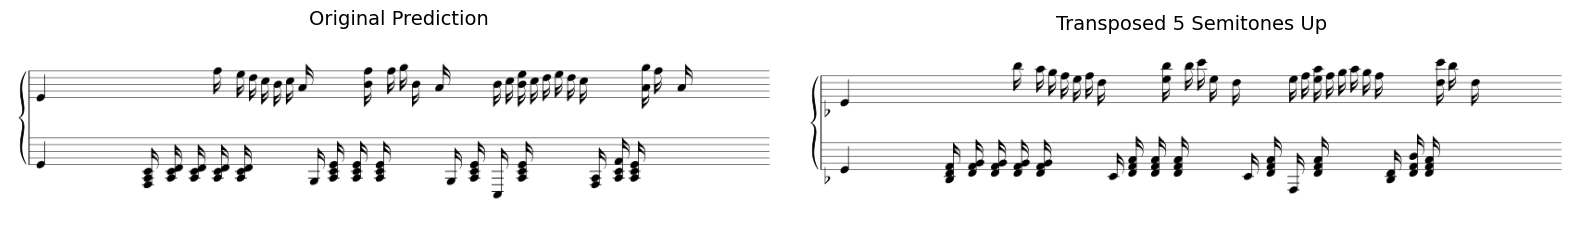

In [6]:
transposed_score = render_with_transposition(kern_str, TRANSPOSE_SEMITONES)
display_comparison(original_score, transposed_score, TRANSPOSE_SEMITONES)